The purpose of this tutorial is to review single-layer autoencoders

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pylab
import sys
# making sure the dl4mt module is on the path 
# -- this path depends upon the location where the notebook is running
# here it is assumed to be the day1/ directory
sys.path.append('../..')

pylab.rcParams['figure.figsize'] = (10.0, 8.0)

In [2]:
import codecs
import re
import json
import random
import math
import os
import gzip
import cPickle
from collections import Counter, defaultdict

import numpy as np
import matplotlib.pyplot as plt
import pylab
import pandas as pd
from scipy.stats import norm
import nltk

In [3]:
%%writefile ../../dl4mt/autoencoder_layer.py
# Uncomment to save this cell to file in order to import it in later notebooks

"""
 Most of this class was taken from the lisa-lab deeplearning tutorials 
 -- https://github.com/lisa-lab/DeepLearningTutorials

"""

import os
import sys
import timeit

import numpy

import theano
import theano.tensor as T
from theano.tensor.shared_randomstreams import RandomStreams

class dA(object):
    """Denoising Auto-Encoder class (dA)

    A denoising autoencoders tries to reconstruct the input from a corrupted
    version of it by projecting it first in a latent space and reprojecting
    it afterwards back in the input space. Please refer to Vincent et al.,2008
    for more details. If x is the input then equation (1) computes a partially
    destroyed version of x by means of a stochastic mapping q_D. Equation (2)
    computes the projection of the input into the latent space. Equation (3)
    computes the reconstruction of the input, while equation (4) computes the
    reconstruction error.

    """

    def __init__(
        self,
        numpy_rng,
        theano_rng=None,
        input=None,
        n_visible=784,
        n_hidden=500,
        W=None,
        W_prime=None,
        bhid=None,
        bvis=None
    ):
        """
        Initialize the dA class by specifying the number of visible units (the
        dimension d of the input ), the number of hidden units ( the dimension
        d' of the latent or hidden space ) and the corruption level. The
        constructor also receives symbolic variables for the input, weights and
        bias. Such a symbolic variables are useful when, for example the input
        is the result of some computations, or when weights are shared between
        the dA and an MLP layer. When dealing with SdAs this always happens,
        the dA on layer 2 gets as input the output of the dA on layer 1,
        and the weights of the dA are used in the second stage of training
        to construct an MLP.

        :type numpy_rng: numpy.random.RandomState
        :param numpy_rng: number random generator used to generate weights

        :type theano_rng: theano.tensor.shared_randomstreams.RandomStreams
        :param theano_rng: Theano random generator; if None is given one is
                     generated based on a seed drawn from `rng`

        :type input: theano.tensor.TensorType
        :param input: a symbolic description of the input or None for
                      standalone dA

        :type n_visible: int
        :param n_visible: number of visible units

        :type n_hidden: int
        :param n_hidden:  number of hidden units

        :type W: theano.tensor.TensorType
        :param W: Theano variable pointing to a set of weights that should be
                  shared belong the dA and another architecture; if dA should
                  be standalone set this to None
                  
        :type W_prime: theano.tensor.TensorType
        :param W_prime: Theano variable pointing to a set of weights that should be
                  shared belong the dA and another architecture; if dA should
                  be standalone set this to None

        :type bhid: theano.tensor.TensorType
        :param bhid: Theano variable pointing to a set of biases values (for
                     hidden units) that should be shared belong dA and another
                     architecture; if dA should be standalone set this to None

        :type bvis: theano.tensor.TensorType
        :param bvis: Theano variable pointing to a set of biases values (for
                     visible units) that should be shared belong dA and another
                     architecture; if dA should be standalone set this to None


        """
        self.n_visible = n_visible
        self.n_hidden = n_hidden

        # create a Theano random generator that gives symbolic random values
        if not theano_rng:
            theano_rng = RandomStreams(numpy_rng.randint(2 ** 30))

        # note : W' was written as `W_prime` and b' as `b_prime`
        if not W:
            # W is initialized with `initial_W` which is uniformly sampled
            # from -4*sqrt(6./(n_visible+n_hidden)) and
            # 4*sqrt(6./(n_hidden+n_visible))the output of uniform if
            # converted using asarray to dtype
            # theano.config.floatX so that the code is runable on GPU
            initial_W = numpy.asarray(
                numpy_rng.uniform(
                    low=-4 * numpy.sqrt(6. / (n_hidden + n_visible)),
                    high=4 * numpy.sqrt(6. / (n_hidden + n_visible)),
                    size=(n_visible, n_hidden)
                ),
                dtype=theano.config.floatX
            )
            W = theano.shared(value=initial_W, name='W', borrow=True)

        # NOTE: this is to "untie" the autoencoder weights-- (this gets overwritten below) 
        # NOTE: If you want to play with untied weights, uncomment this section,
        # and comment the `W_prime` initialization below 
#         if not W_prime:
#             initial_W_prime = numpy.asarray(
#                 numpy_rng.uniform(
#                     low=-4 * numpy.sqrt(6. / (n_hidden + n_visible)),
#                     high=4 * numpy.sqrt(6. / (n_hidden + n_visible)),
#                     size=(n_hidden, n_visible)
#                 ),
#                 dtype=theano.config.floatX
#             )
#             W_prime = theano.shared(value=initial_W_prime, name='W', borrow=True)

            
        if not bvis:
            bvis = theano.shared(
                value=numpy.zeros(
                    n_visible,
                    dtype=theano.config.floatX
                ),
                borrow=True
            )

        if not bhid:
            bhid = theano.shared(
                value=numpy.zeros(
                    n_hidden,
                    dtype=theano.config.floatX
                ),
                name='b',
                borrow=True
            )

        self.W = W
        # b corresponds to the bias of the hidden
        self.b = bhid
        # b_prime corresponds to the bias of the visible
        self.b_prime = bvis
        
        # Autoencoder with tied weights, therefore W_prime is W transpose
        self.W_prime = self.W.T
#         uncomment to "untie" weights
#         self.W_prime = W_prime
        
        self.theano_rng = theano_rng
        # if no input is given, generate a variable representing the input
        if input is None:
            # we use a matrix because we expect a minibatch of several
            # examples, each example being a row
            self.x = T.dmatrix(name='input')
        else:
            self.x = input

        self.params = [self.W, self.b, self.b_prime]

    def get_corrupted_input(self, input, corruption_level):
        """This function keeps ``1-corruption_level`` entries of the inputs the
        same and zero-out randomly selected subset of size ``coruption_level``
        Note : first argument of theano.rng.binomial is the shape(size) of
               random numbers that it should produce
               second argument is the number of trials
               third argument is the probability of success of any trial

                this will produce an array of 0s and 1s where 1 has a
                probability of 1 - ``corruption_level`` and 0 with
                ``corruption_level``

                The binomial function return int64 data type by
                default.  int64 multiplicated by the input
                type(floatX) always return float64.  To keep all data
                in floatX when floatX is float32, we set the dtype of
                the binomial to floatX. As in our case the value of
                the binomial is always 0 or 1, this don't change the
                result. This is needed to allow the gpu to work
                correctly as it only support float32 for now.

        """
        return self.theano_rng.binomial(size=input.shape, n=1,
                                        p=1 - corruption_level,
                                        dtype=theano.config.floatX) * input
 
    def get_hidden_values(self, input):
        """ Computes the values of the hidden layer """
        return T.nnet.sigmoid(T.dot(input, self.W) + self.b)
    
    def predict(self, input):
        """ Alias to get_hidden_values for consistent API """
        return self.get_hidden_values(input)

    def get_reconstructed_input(self, hidden):
        """Computes the reconstructed input given the values of the
        hidden layer

        """
        return T.nnet.sigmoid(T.dot(hidden, self.W_prime) + self.b_prime)

    def get_cost_updates(self, corruption_level, learning_rate):
        """ This function computes the cost and the updates for one trainng
        step of the dA """

        tilde_x = self.get_corrupted_input(self.x, corruption_level)
        y = self.get_hidden_values(tilde_x)
        z = self.get_reconstructed_input(y)
        
        # sum over the columns of each training instance
        L = - T.sum(self.x * T.log(z) + (1 - self.x) * T.log(1 - z), axis=1)
        
        # note : L is now a vector, where each element is the
        #        cross-entropy cost of the reconstruction of the
        #        corresponding example of the minibatch. We need to
        #        compute the average of all these to get the cost of
        #        the minibatch
        cost = T.mean(L)

        # compute the gradients of the cost of the `dA` with respect
        # to its parameters
        gparams = T.grad(cost, self.params)
        # generate the list of updates
        updates = [
            (param, param - learning_rate * gparam)
            for param, gparam in zip(self.params, gparams)
        ]

        return (cost, updates)


Overwriting ../../dl4mt/autoencoder_layer.py


In [4]:
import numpy
import theano
import theano.tensor as T
import timeit
from theano.tensor.shared_randomstreams import RandomStreams

from dl4mt.autoencoder_layer import dA

# TODO: remove training_epochs param
def initialize_dA(train_dataset, learning_rate=0.1, corruption_level=0.0, batch_size=10, n_hidden=2):
    """ Initialize the parameters and functions for the denoising autoencoder
    
    :type train_dataset: tuple
    :param train_dataset: a tuple consisting of (X,y) for the training dataset
                          (X and y are theano shared variables)
                          
    :type learning_rate: float
    :param learning_rate: learning rate used (factor for the stochastic
                          gradient)

    :type corruption_level: float
    :param corruption_level: the probability of "dropping out" an input feature

    :type batch_size: int
    :param batch_size: the minibatch size for training and validation 
    
    :type n_hidden: int
    :param n_hidden: the size of the hidden layer
    
    """
    
    train_set_x, train_set_y = train_dataset
        
    # compute number of minibatches for training, validation and testing
    n_train_batches = train_set_x.get_value(borrow=True).shape[0] / batch_size

    # allocate symbolic variables for the data
    index = T.lscalar()    # index to a [mini]batch
    x = T.matrix('x')  # the data will be concatenated word vector windows

    rng = numpy.random.RandomState(123)
    theano_rng = RandomStreams(rng.randint(2 ** 30))

    da = dA(
        numpy_rng=rng,
        theano_rng=theano_rng,
        input=x,
        n_visible=train_set_x.get_value().shape[1],
        n_hidden=n_hidden
    )

    cost, updates = da.get_cost_updates(
        corruption_level=corruption_level,
        learning_rate=learning_rate
    )

    train_model_func = theano.function(
        [index],
        cost,
        updates=updates,
        givens={
            x: train_set_x[index * batch_size: (index + 1) * batch_size]
        }
    )
    
#     classifier, train_model_func, validate_model_func, n_train_batches, n_valid_batches
    return (da, train_model_func, None, n_train_batches, 0)

In [5]:
from dl4mt.datasets import prep_dataset
from dl4mt.training import train_model

DATASET_LOCATION = '../../datasets/'

# the pos dataset consists of windows around words
POS_DATASET_NAME = 'brown_pos_dataset.hdf5'
POS_DATASET_PATH = os.path.join(DATASET_LOCATION, POS_DATASET_NAME)

CORPUS_INDICES = 'brown_pos_dataset.indices'
WORD_BY_WORD_MATRIX = 'brown.word-by-word.normalized.npy'

# load the training data
VECTOR_INDEX_PATH = os.path.join(DATASET_LOCATION, WORD_BY_WORD_MATRIX)
CUTOFF = 10000
  
train_dataset = prep_dataset(POS_DATASET_PATH, VECTOR_INDEX_PATH, which_sets=['train'], cutoff=CUTOFF)

# initialize the autoencoder model
initialization_data = initialize_dA(train_dataset, learning_rate=0.1,
                                    corruption_level=0.3, batch_size=50, n_hidden=2)

classifier, train_model_func, validate_model_func, n_train_batches, n_valid_batches = initialization_data
    
# load the training function and train the LR model 
# in general, train_model should return any useful information about the training process
train_model(train_model_func,  n_train_batches, validate_model=validate_model_func,
            n_valid_batches=n_valid_batches, training_epochs=10)

epoch 1, average training cost 290.86
epoch 2, average training cost 273.08
epoch 3, average training cost 267.58
epoch 4, average training cost 265.69
epoch 5, average training cost 264.92
epoch 6, average training cost 264.56
epoch 7, average training cost 264.32
epoch 8, average training cost 264.15
epoch 9, average training cost 263.88
epoch 10, average training cost 263.59
Optimization complete!


In [6]:
# make a theano function to get predictions from a trained model
training_data = theano.tensor.matrix('training_X')
predictions = classifier.predict(training_data)
get_predictions = theano.function([training_data], predictions)
# get predictions and evaluate
p = get_predictions(train_dataset[0].get_value())

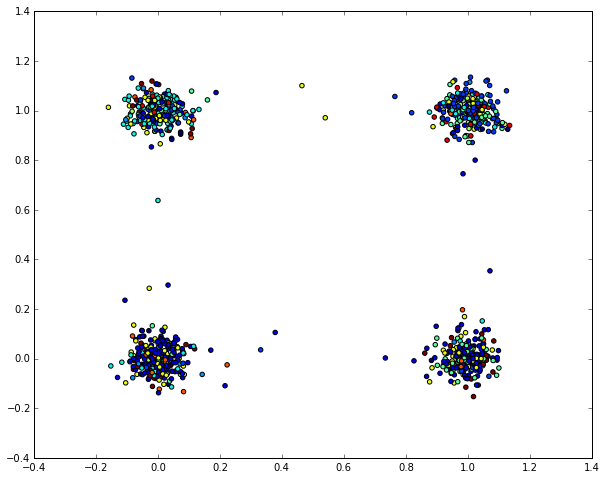

In [7]:
# %matplotlib qt
# uncomment above if you want to pan and zoom in a separate window

# import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# get train_y without the cast
train_y = prep_dataset(POS_DATASET_PATH, VECTOR_INDEX_PATH, which_sets=['train'],
                       cast_y=False, cutoff=CUTOFF)[1].get_value().astype('int32')

# TODO: Set this at the top of the notebook -- this is the visualization cutoff, not the training cutoff
CUTOFF_BEGIN=0
CUTOFF_END=1000

# TODO: this method of visualizing the labels loses the class tags -- we want to know which color is which
y_vals = train_y[CUTOFF_BEGIN:CUTOFF_END]
norm_y_vals = y_vals / float(np.amax(y_vals))

jitter1 = np.random.normal(loc=0.0, scale=0.05, size=CUTOFF_END-CUTOFF_BEGIN)
jitter2 = np.random.normal(loc=0.0, scale=0.05, size=CUTOFF_END-CUTOFF_BEGIN)
x1 = p[CUTOFF_BEGIN:CUTOFF_END,0] + jitter1
x2 = p[CUTOFF_BEGIN:CUTOFF_END,1] + jitter2


plt.scatter(x1, x2, c=norm_y_vals, s=20)
plt.show()

In [8]:
y_counts = Counter(y_vals)
y_counts

Counter({0: 17,
         1: 319,
         2: 118,
         3: 19,
         4: 133,
         5: 125,
         6: 12,
         7: 152,
         9: 18,
         10: 31,
         11: 56})